<a href="https://colab.research.google.com/github/josephzonghaozhu/drone-photography-semantic-segmentation/blob/main/Drone_Photography_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DRONE AERIAL PHOTOGRAPHY - semantic segmentation

# ABOUT THE DATASET

400 aerial nadir images of size 6000x4000px (24Mpx), captured at altitudes of 5 to 30 meters above ground. To improve semantic understanding of urban environments and increase the safety of autonomous drone flight and landing procedures. 

In [ ]:
#variable explorer

#from google.colab import output
#with output.temporary():
#  !pip install --upgrade git+https://github.com/Kreijstal/colab_inspector.git 
#  !python2.7 -m pip install --upgrade git+https://github.com/blois/colab_inspector.git      ##nbextensions don't work with python3.6 
#  !jupyter nbextension install --py inspector

#import inspector

# open a scratch cell (Ctrl+Alt+N) & run: inspector.watch_globals()

In [ ]:
!rm -rf /content/sample_data      #remove colab default folder

In [ ]:
import os
import zipfile

import pandas as pd

In [ ]:
from google.colab import files
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset -p /content
!unzip -q -n /content/semantic-drone-dataset.zip -d /content
!rm /content/semantic-drone-dataset.zip

100% 3.88G/3.89G [00:29<00:00, 154MB/s]
100% 3.89G/3.89G [00:29<00:00, 143MB/s]


In [ ]:
DATA_DIR = '/content/dataset/semantic_drone_dataset'
IMAGE_DIR = DATA_DIR + '/original_images'
MASK_DIR = DATA_DIR + '/label_images_semantic'

COLOR_MASK_DIR = '/content/RGB_color_image_masks/RGB_color_image_masks'

In [ ]:
class_dict = pd.read_csv('/content/class_dict_seg.csv')
print(class_dict)

           name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0


In [ ]:
print(class_dict.columns)     #rgb column names are indented

Index(['name', ' r', ' g', ' b'], dtype='object')


In [ ]:
cmap = class_dict[[' r', ' g', ' b']].values      #cmap = np.array(list(class_dict[[' r', ' g', ' b']].transpose().to_dict('list').values()))
print(cmap)

[[  0   0   0]
 [128  64 128]
 [130  76   0]
 [  0 102   0]
 [112 103  87]
 [ 28  42 168]
 [ 48  41  30]
 [  0  50  89]
 [107 142  35]
 [ 70  70  70]
 [102 102 156]
 [254 228  12]
 [254 148  12]
 [190 153 153]
 [153 153 153]
 [255  22  96]
 [102  51   0]
 [  9 143 150]
 [119  11  32]
 [ 51  51   0]
 [190 250 190]
 [112 150 146]
 [  2 135 115]
 [255   0   0]]


# PREVIEW IMAGES & MASKS

In [ ]:
import cv2

img = cv2.imread(IMAGE_DIR + '/000.jpg')
print('Image shape : {}'.format(img.shape))
mask = cv2.imread(MASK_DIR + '/000.png')
print('Mask shape : {}'.format(mask.shape))
total_samples = len(os.listdir(IMAGE_DIR))
print('Total number of images : {}'.format(total_samples))      #various numbered samples are missing eg '012'

Image shape : (4000, 6000, 3)
Mask shape : (4000, 6000, 3)
Total number of images : 400


In [ ]:
from glob import glob
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

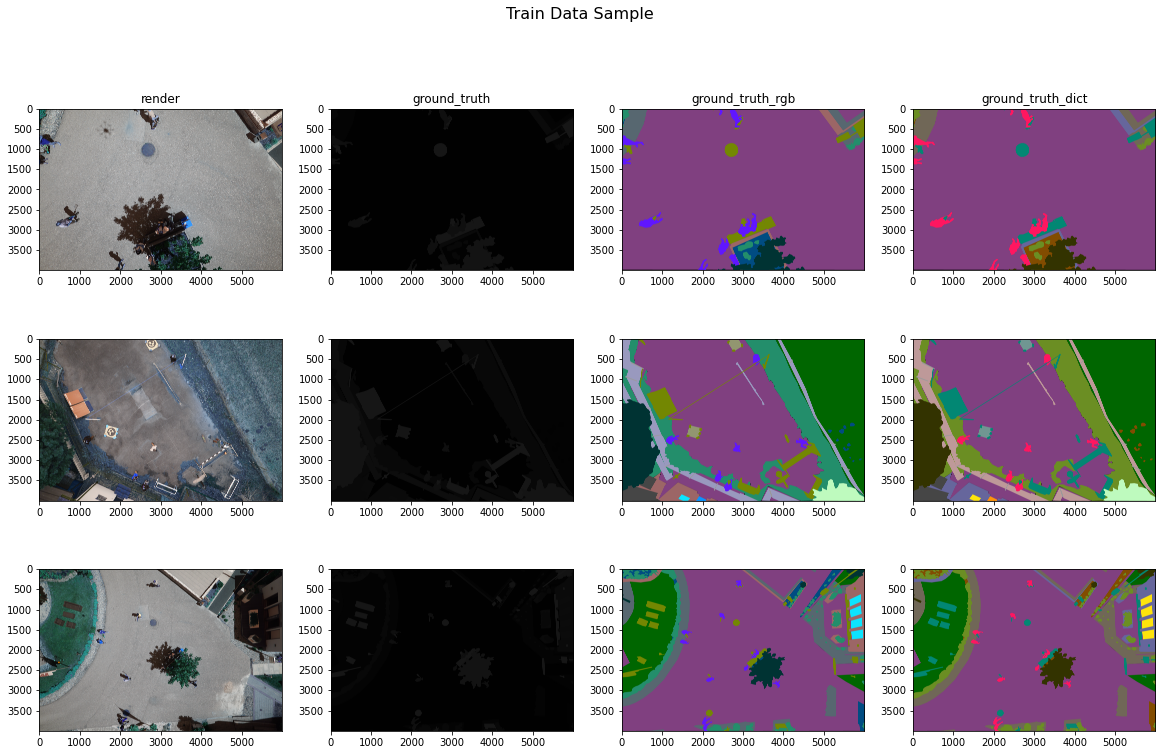

In [ ]:
fig = plt.figure(figsize=(20,12))
rows = 3
cols = 4

for i in range(rows):
  path = IMAGE_DIR + '/' + str(i).zfill(3) + '.jpg'
  img = cv2.imread(path)
  plt.subplot(rows, cols, i*cols+1)
  plt.imshow(img)
  if i==0:
    plt.title('render')

  path = MASK_DIR + '/' + str(i).zfill(3) + '.png'
  img = cv2.imread(path)      #cv2.IMREAD_UNCHANGED/_GRAYSCALE gives shape (4000, 6000) rather than (4000, 6000, 3)
  plt.subplot(rows, cols, i*cols+2)
  plt.imshow(img)
  if i==0:
    plt.title('ground_truth')

  path = COLOR_MASK_DIR + '/' + str(i).zfill(3) + '.png'
  img = cv2.imread(path)
  plt.subplot(rows, cols, i*cols+3)
  plt.imshow(img)
  if i==0:
    plt.title('ground_truth_rgb')

  path = MASK_DIR + '/' + str(i).zfill(3) + '.png'
  img = cv2.imread(path)[:, :, 0]
  plt.subplot(rows, cols, i*cols+4)
  plt.imshow(cmap[img])
  if i==0:
    plt.title('ground_truth_dict')
  if i==rows-1:
    plt.suptitle('Train Data Sample', fontsize=16)

In [ ]:
#peek at mask pixel values

mask = cv2.imread(MASK_DIR + '/000.png')
print(mask)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [ ]:
label = cv2.imread(MASK_DIR + '/000.png')[:, :, 0]      #all 3 color channels share the same value, ie. 0-23 as per classs
print(label)
print(label.shape)
label = cv2.resize(label, (1200,800))     #resize to reduce computational load
print('\n', '_', '\n', label)
print(label.shape)
label = np.array(label)     #not needed for plt., needed for np.
print('\n', '_', '\n', label)
print(label.shape)
#label = label.flatten()      #for cm 
#print('\n', '_', '\n', label)
#label = label.reshape(-1, 800, 1200)
#print('\n', '_', '\n', label)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(4000, 6000)

 _ 
 [[0 8 8 ... 1 1 1]
 [0 8 8 ... 1 1 1]
 [0 8 8 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]]
(800, 1200)

 _ 
 [[0 8 8 ... 1 1 1]
 [0 8 8 ... 1 1 1]
 [0 8 8 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]]
(800, 1200)


# HYPERPARAMETERS

In [ ]:
num_classes = 23      # 0 is 'unlabelled', 23 is 'conflicting'
W = 1200
H = 800
C = 3
input_shape = (H,W,C)

epochs = 30
lr = 1.3e-5     
starting_neurons = 16

batch_size = 3

# DATA AUGMENTATION

In [ ]:
import albumentations as A
from tqdm import tqdm

def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)
        
def augment_data(images, masks, save_path, iterations=0, include_original=False):
  aug = A.Compose([
      A.RandomCrop(int(H*4/5), int(W*4/5), always_apply=False, p=0.5),
      A.HorizontalFlip(always_apply=False, p=0.5),
      A.VerticalFlip(always_apply=False, p=0.5)
      ])

  for x,y in tqdm(zip(images, masks), total=len(images)):     #, total=len(images), miniters=len(images)//100
    name = os.path.basename(x).split('.')
    img_name = name[0]
    img_ext = name[1]
    name = os.path.basename(y).split('.')
    msk_name = name[0]
    msk_ext = name[1]       
        
    x = cv2.imread(x, cv2.IMREAD_COLOR)     #or cv2.COLOR_BGR2RGB, albumentations uses RGB 
    x = cv2.resize(x, (W,H))
    y = cv2.imread(y, cv2.IMREAD_COLOR)
    y = cv2.resize(y, (W,H))
        
    auged_images = []
    auged_masks = []

    if (include_original):
      auged_images.append(x)      #append unaugmented originals
      auged_masks.append(y)

    for _ in range(iterations):
      auged = aug(image=x, mask=y)
      auged_images.append(auged['image'])
      auged_masks.append(auged['mask'])
                
    n = 0
    for i,m in zip(auged_images, auged_masks):
      i = cv2.resize(i, (W,H))
      m = cv2.resize(m, (W,H))
            
      img_fullname = f'{img_name}_{n}.{img_ext}'
      msk_fullname = f'{msk_name}_{n}.{msk_ext}' 
            
      image_path = os.path.join(save_path, 'images', img_fullname)
      mask_path = os.path.join(save_path, 'masks', msk_fullname)
           
      cv2.imwrite(image_path, i)
      cv2.imwrite(mask_path, m)

      n+=1

In [ ]:
images = sorted(glob(os.path.join(DATA_DIR + '/', 'original_images/*')))
masks = sorted(glob(os.path.join(DATA_DIR + '/', 'label_images_semantic/*')))
print('Original images : {}'.format(len(images)))
print('Original masks : {}'.format(len(masks)))

create_dir('/content/new_data/images/')
create_dir('/content/new_data/masks/')

save_path = '/content/new_data/'

augment_data(images, masks, save_path, iterations=2, include_original=True)

images = sorted(glob(os.path.join(save_path, 'images/*')))
masks = sorted(glob(os.path.join(save_path, 'masks/*')))
print('\n','Augmented images : {}'.format(len(images)))
print('Augmented masks : {}'.format(len(masks)))

Original images : 400
Original masks : 400


100%|██████████| 400/400 [05:21<00:00,  1.24it/s]


 Augmented images : 1200
Augmented masks : 1200


In [ ]:
IMAGE_DIR = '/content/new_data/images'     #reassign DIRs
MASK_DIR = '/content/new_data/masks'
total_samples = len(images)     #reassign total_samples

In [ ]:
def rename_post_aug(dir):
  n=0
  for path in sorted(glob(dir + '/*')):
    dir = os.path.dirname(path)
    ext = os.path.splitext(path)[1]
    name = str(n).zfill(4)
    os.rename(path, dir + '/' + name + ext)
    n+=1 

rename_post_aug(IMAGE_DIR)
rename_post_aug(MASK_DIR)

print('Augmented images : {}'.format(len(os.listdir(IMAGE_DIR))))
print('Augmented masks : {}'.format(len(os.listdir(MASK_DIR))))
total_samples = len(os.listdir(IMAGE_DIR))      #reassign total_samples

Augmented images : 1200
Augmented masks : 1200


In [ ]:
#check new dataset for correct pixel values in case of interpolation on masks 
#invalid

#mask = cv2.imread(MASK_DIR + '/0000.png')
#print(mask.shape)
#print(np.unique(mask))
#plt.imshow(mask)
#mask = cv2.imread(sorted(glob(DATA_DIR + '/label_images_semantic/*'))[0])
#print(mask.shape)
#print(np.unique(mask))
#plt.imshow(mask)

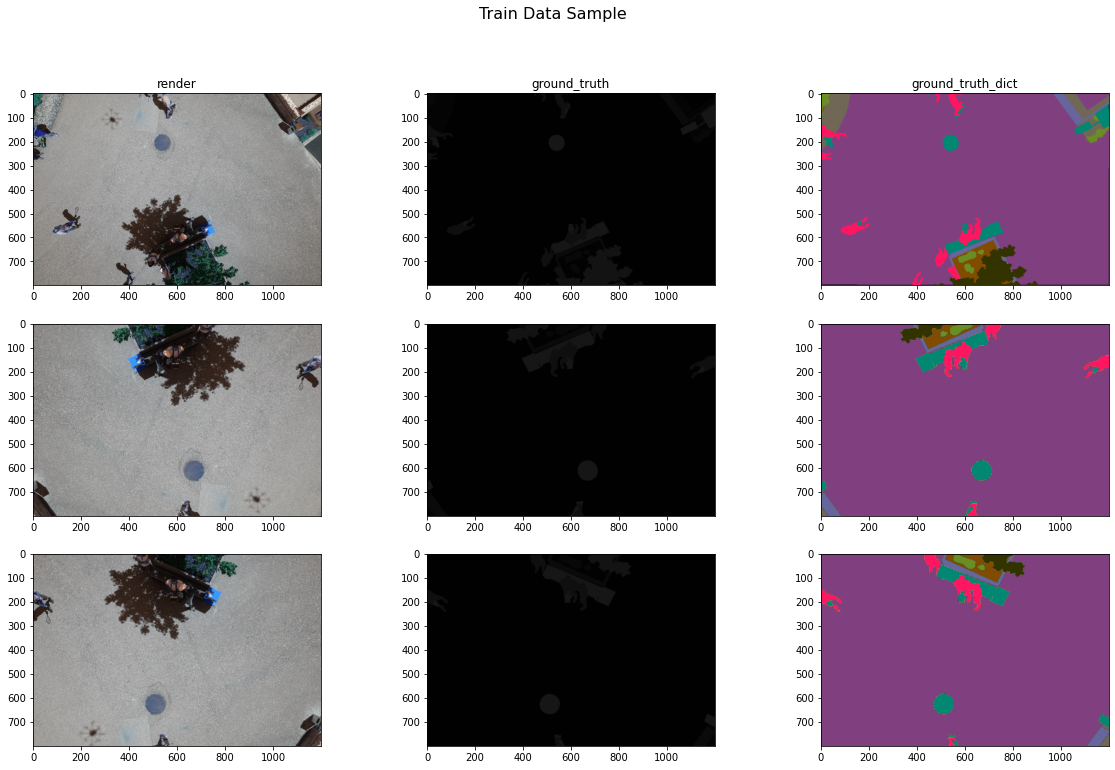

In [ ]:
#check new dataset visually

fig = plt.figure(figsize=(20,12))
rows = 3
cols = 3

for i in range(rows):
  path = IMAGE_DIR + '/' + str(i).zfill(4) + '.jpg'
  img = cv2.imread(path)
  plt.subplot(rows, cols, i*cols+1)
  plt.imshow(img)
  if i==0:
    plt.title('render')

  path = MASK_DIR + '/' + str(i).zfill(4) + '.png'
  img = cv2.imread(path)      #,cv2.IMREAD_UNCHANGED/_GRAYSCALE gives shape (4000, 6000) instead of (4000, 6000, 3)
  plt.subplot(rows, cols, i*cols+2)
  plt.imshow(img)
  if i==0:
    plt.title('ground_truth')

  path = MASK_DIR + '/' + str(i).zfill(4) + '.png'
  img = cv2.imread(path)[:, :, 0]
  plt.subplot(rows, cols, i*cols+3)
  plt.imshow(cmap[img])
  if i==0:
    plt.title('ground_truth_dict')
  if i==rows-1:
    plt.suptitle('Train Data Sample', fontsize=16)

# CLASS IMBALANCE

In [ ]:
masks = []
for path in glob(MASK_DIR + '/*'):    
  mask = cv2.imread(path)
  mask = cv2.resize(mask, (int(W/4),int(H/4)))      #resize to avoid memory issues
  masks.append(mask)

masks = np.array(masks, dtype=np.int8)
labels = masks.flatten()
#unique_labels = np.unique(labels)      #computationally expensive, so use unique_labels = [list(range(num_classes))]
unique_labels = np.array(list(range(num_classes)), dtype=np.int8)      #

print(labels.shape)
print(unique_labels)

(216000000,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [ ]:
labels_series = pd.Series(labels).value_counts(sort=True, ascending=True)      #sort by frequency
labels_sorted = [labels_series[k] for i,k in enumerate(sorted(dict(labels_series)))]
total = sum(labels_sorted)
#print(total)     #should equal print(len(labels))

class_weights = {}
for i,num in enumerate(labels_sorted):
  class_weights[i] = round((total/num)*(1/num_classes), 8)

print(class_weights)
print(sum(class_weights.values()))

{0: 174.31008311, 1: 0.11388546, 2: 1.34802089, 3: 0.21360749, 4: 0.61518066, 5: 1.78071812, 6: 4.82288717, 7: 5.09492626, 8: 0.63586503, 9: 0.61913824, 10: 1.79089219, 11: 7.6438574, 12: 27.91715893, 13: 4.72340929, 14: 57.94526104, 15: 4.17806325, 16: 83.16555837, 17: 5.06005726, 18: 17.93123372, 19: 2.21707362, 20: 3.42324551, 21: 17.69306948, 22: 1.32763679}
424.57082928


# DATASET PIPELINE & PREPROCESSING

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
#from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from keras.utils.vis_utils import plot_model

tf.__version__

'2.8.2'

In [ ]:
#x = cv2.imread(MASK_DIR + '/0000.png')      #0000,000
#print(x.shape)
#x = cv2.imread(MASK_DIR + '/0000.png', cv2.IMREAD_GRAYSCALE)
#print(x.shape)
#x = cv2.resize(x, (W, H))
#print(x.shape)
#print(x)
#x = x.astype(np.int32)

# difference between tf.keras.backend.one_hot and keras.utils.to_categorical:
# utils.to_categorical function takes a vector as input and returns a matrix with one hot encoded rows.
# backend.one_hot can be called as a transformation step inbetween a compute sequence of tensors.
# It takes nD tensor as input and returns n+1 D one hot encoded tensor.

In [ ]:
# dataset pipeline for train&valid
#variables: total_samples, W, H, C, IMAGE_DIR, MASK_DIR
#hard code: extensions

def read_image(x):
  x = cv2.imread(x, cv2.IMREAD_COLOR)      #or cv2.IMREAD_COLOR, cv2_IMREAD_UNCHANGED
  x = cv2.resize(x, (W,H))
  x = x/255.
  x = x.astype(np.float32)
  return x

def read_mask(x):
  x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)     #if cv2.COLOR_BGR2RGB -> Incompatible shapes at component 1: expected [?,128,128,3] but got [16,128,128,3,3].
  x = cv2.resize(x, (W,H))
  x = x.astype(np.int32)
  return x

def preprocess(x,y):
  def f(x,y):
    x = x.decode()
    y = y.decode()
    image = read_image(x)
    mask = read_mask(y)
    return image,mask
  
  image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])     #tf.numpy_function, takes np arrays & return tf data type (f must take & return np arrays), wraps a python f and uses it as a tensorflow op
  mask = tf.one_hot(mask, num_classes, dtype=tf.int32)      
  image.set_shape([H, W, C])    
  mask.set_shape([H, W, num_classes])
  return image, mask

def tf_dataset(x, y, batch_size=4):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))     #tf dataset object
  dataset = dataset.shuffle(buffer_size = total_samples)      #uniformly shuffles entire dataset, ok if can store entire dataset in memory, https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(2)     #decouple the time when data is produced from the time when data is consumed
  return dataset

In [ ]:
# dataset pipeline for test

def preprocess_test(x):
  def f(x):
    x = x.decode()
    image = read_image(x)
    return image
    
  image = tf.convert_to_tensor(tf.numpy_function(f, [x], [tf.float32]))
  image = tf.reshape(image, (H, W, C))      
  return image

def tf_dataset_test(x, batch_size=4):
  dataset = tf.data.Dataset.from_tensor_slices(x)
  dataset = dataset.map(preprocess_test)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(2)
  return dataset

In [ ]:
# get paths & split

from sklearn.model_selection import train_test_split

names = [os.path.basename(path).replace('.jpg', '') for path in glob(IMAGE_DIR + '/*')]      #using names to ensure x matches y, or can iterate through 'sorted(glob())' in data with no missing samples, although it is pre-sorted in this case

n_train, n_val = train_test_split(names, test_size=0.1, random_state=1)

print('train samples : {}'.format(len(n_train)))
print('valid samples : {}'.format(len(n_val)))

x_train = [os.path.join(IMAGE_DIR + '/' + str(n) + '.jpg') for n in n_train]
y_train = [os.path.join(MASK_DIR + '/' + str(n) + '.png') for n in n_train]
x_valid = [os.path.join(IMAGE_DIR + '/' + str(n) + '.jpg') for n in n_val]
y_valid = [os.path.join(MASK_DIR + '/' + str(n) + '.png') for n in n_val]

print(x_train[:2])
print(y_train[:2])
print(x_valid[:2])
print(y_valid[:2])

train samples : 1080
valid samples : 120
['/content/new_data/images/1120.jpg', '/content/new_data/images/0415.jpg']
['/content/new_data/masks/1120.png', '/content/new_data/masks/0415.png']
['/content/new_data/images/0187.jpg', '/content/new_data/images/0160.jpg']
['/content/new_data/masks/0187.png', '/content/new_data/masks/0160.png']


In [ ]:
# include only original non-augmented data as test samples

names = [os.path.basename(path).replace('.jpg', '') for path in glob(DATA_DIR + '/original_images' + '/*')]
n_unused, n_test = train_test_split(names, test_size=0.1, random_state=1)

print('test samples : {}'.format(len(n_test)))

x_test = [os.path.join(DATA_DIR + '/original_images' + '/' + str(n) + '.jpg') for n in n_test]
y_test = [os.path.join(DATA_DIR + '/label_images_semantic' + '/' + str(n) + '.png') for n in n_test]

print(x_test[:2])
print(y_test[:2])

test samples : 40
['/content/dataset/semantic_drone_dataset/original_images/427.jpg', '/content/dataset/semantic_drone_dataset/original_images/079.jpg']
['/content/dataset/semantic_drone_dataset/label_images_semantic/427.png', '/content/dataset/semantic_drone_dataset/label_images_semantic/079.png']


In [ ]:
# get tf datasets for train&valid

train_dataset = tf_dataset(x_train, y_train, batch_size=batch_size) 
valid_dataset = tf_dataset(x_valid, y_valid, batch_size=batch_size)

train_steps = len(x_train)//batch_size
valid_steps = len(x_valid)//batch_size

print(train_dataset)
print(valid_dataset)

print(train_steps)
print(valid_steps)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 800, 1200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 800, 1200, 23), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 800, 1200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 800, 1200, 23), dtype=tf.int32, name=None))>
360
40


# U-NET 

In [ ]:
def down_block(x, filters, kernel_size=(3,3), padding='same', strides=1, activation='relu'):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(x)
    #c  = BatchNormalization()(c)     
    #c = Dropout(0.1)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(c)
    #c  = BatchNormalization()(c)     
    p = MaxPooling2D((2,2))(c)
    return c,p

def bottleneck(x, filters, kernel_size=(3,3), padding='same', strides=1, activation='relu'):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(x)
    #c  = BatchNormalization()(c)
    #c = Dropout(0.1)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(c)
    #c  = BatchNormalization()(c)
    return c

def up_block(x, skip, filters, kernel_size=(3,3), padding='same', strides=1, activation='relu'):
    up = Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding="same")(x)      #Conv2DTranspose() is similar to UpSampling2D() + Conv2D, ie. upsamples AND learns what kernel is best, UpSampling2D() has no learned parameters
    concat = Concatenate()([up,skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(concat)
    #c  = BatchNormalization()(c)
    #c = Dropout(0.1)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(c)
    #c  = BatchNormalization()(c)
    return c

In [ ]:
def unet(num_classes, input_shape, starting_neurons):
    i = Input(shape=input_shape)
    f = starting_neurons

    # downsample
    c1, p1 = down_block(i, f)
    c2, p2 = down_block(p1, f*2)
    c3, p3 = down_block(p2, f*4)
    c4, p4 = down_block(p3, f*8)

    # bottleneck
    bn = bottleneck(p4, f*16)

    # upsample
    u1 = up_block(bn, c4, f*8)
    u2 = up_block(u1, c3, f*4)
    u3 = up_block(u2, c2, f*2)
    u4 = up_block(u3, c1, f)

    output = Conv2D(num_classes, (1,1), activation='softmax')(u4)     #softmax, sigmoid if 2 classes

    model = Model(inputs=[i], outputs=[output])
    return model

In [ ]:
def multi_unet_model(n_classes=23, IMG_HEIGHT=800, IMG_WIDTH=1200, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    # compile the model in the main program to make it easy to test with various loss functions
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    return model

# MODEL TRAINING

In [ ]:
# adam optimizer already handles lr decay individually for each parameter

#callback_lr = tf.keras.callbacks.ReduceLROnPlateau(
#    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=1e-6)
#)

In [ ]:
# callback_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=10, verbose=1, restore_best_weights=False)

In [ ]:
# callback_save = tf.keras.callbacks.ModelCheckpoint(
#     '/content/model/saved', monitor='val_loss', mode='min', verbose=1, save_best_only=True,
#     save_weights_only=False, save_freq='epoch')

In [ ]:
model = unet(num_classes, input_shape, starting_neurons)
model.summary()

model.compile(optimizer = Adam(learning_rate=lr), loss ='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 1200, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 1200, 16 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 800, 1200, 16 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 400, 600, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
plot_model(model, to_file='model.pdf', show_shapes=True, show_dtype=True,
          show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
          )

In [ ]:
history = model.fit(
    train_dataset, 
    steps_per_epoch=train_steps,        
    epochs=epochs, 
    verbose=1,
    validation_data = valid_dataset, 
    validation_steps=valid_steps,      
    #class_weight=class_weights
    #callbacks=[callback_save]
)

Epoch 1/30
324/324 [==============================] - 436s 1s/step - loss: 2.5509 - accuracy: 0.3618 - val_loss: 2.2659 - val_accuracy: 0.3624
Epoch 2/30
324/324 [==============================] - 389s 1s/step - loss: 2.1703 - accuracy: 0.3898 - val_loss: 2.0426 - val_accuracy: 0.3631
Epoch 3/30
324/324 [==============================] - 393s 1s/step - loss: 1.9760 - accuracy: 0.3966 - val_loss: 1.8216 - val_accuracy: 0.3805
Epoch 4/30
324/324 [==============================] - 389s 1s/step - loss: 1.7673 - accuracy: 0.5000 - val_loss: 1.6119 - val_accuracy: 0.5662
Epoch 5/30
324/324 [==============================] - 393s 1s/step - loss: 1.5657 - accuracy: 0.5690 - val_loss: 1.3961 - val_accuracy: 0.6104
Epoch 6/30
324/324 [==============================] - 393s 1s/step - loss: 1.3992 - accuracy: 0.6097 - val_loss: 1.3168 - val_accuracy: 0.6343
Epoch 7/30
324/324 [==============================] - 394s 1s/step - loss: 1.3393 - accuracy: 0.6221 - val_loss: 1.2069 - val_accuracy: 0.6649

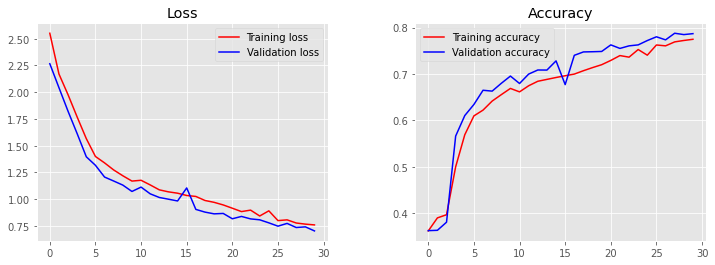

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 4))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend(loc=0)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend(loc=0)

plt.subplots_adjust(wspace=0.3)
plt.show()

In [ ]:
# model.save('/content/model/endpt')
# !zip -r /content/model/endpt.zip /content/model/endpt

In [ ]:
# tf.keras.backend.clear_session()
# train_generator.reset()
# valid_generator.reset()

# MODEL EVALUATION 

In [ ]:
test_dataset = tf_dataset(x_test, y_test, batch_size = batch_size)      #but test batch size can generally be larger
test_steps = len(x_test)//batch_size

model.evaluate(test_dataset, steps=test_steps)

13/13 [==============================] - 136s 10s/step - loss: 0.4269 - accuracy: 0.8648


[0.4268721640110016, 0.8647878170013428]

In [ ]:
pred = model.predict(tf_dataset_test(x_test, batch_size = 1))
print(pred.shape)

(40, 800, 1200, 23)


In [ ]:
MASK_DIR = DATA_DIR + '/label_images_semantic'

y_pred = np.argmax(pred, axis=3)      #find max at dim 3
y_true = np.array([cv2.resize(cv2.imread(MASK_DIR+'/'+x_test[i][-7:-4]+'.png')[:, :, 0], (1200, 800)) for i in range(y_pred.shape[0])])
y_true = y_true.flatten()
y_pred = y_pred.flatten()

print(y_pred.shape)

(38400000,)


In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
df_cm = pd.DataFrame(cm,  columns=list(class_dict['name'])[:num_classes])
df_cm

,unlabeled,paved-area,dirt,grass,gravel,water,rocks,pool,vegetation,roof,...,fence,fence-pole,person,dog,car,bicycle,tree,bald-tree,ar-marker,obstacle
0,924,25273,2734,7789,7474,2069,0,119,4673,2045,...,107,0,11,0,46,0,219,95,5,908
1,979,14916430,94526,17220,132559,11742,0,1568,22429,144219,...,438,0,67452,0,7591,1622,1423,27373,1167,69042
2,748,35715,896643,48951,17761,111,0,0,58221,52,...,59,0,452,0,0,5,105,9158,0,7669
3,414,54393,144748,8584502,972,15771,0,0,58561,764,...,385,0,1588,0,12,4268,1176,34101,114,5648
4,112,123106,56652,2429,2315714,3902,1427,0,82096,1976,...,300,0,611,0,0,70,10,799,9,20704
5,226,1589,3608,964,2759,1150515,1249,1658,33759,1088,...,101,0,7,0,0,34,935,2,24,9484
6,21,4513,19022,338,200422,25649,9082,0,111053,0,...,185,0,0,0,0,0,56,828,0,13391
7,0,4819,0,6,0,10924,0,587098,0,32,...,0,0,1,0,594,5,0,0,2734,5128
8,273,18396,318619,56782,65859,22096,6,0,1269819,59,...,610,0,81,0,0,10,26928,3302,0,21832
9,5,57188,1505,774,47162,434,0,0,611,1986753,...,177,0,21,0,0,54,1,15,0,6221


In [ ]:
#MIoU: MIoU (Mean Intersection over Union), Jaccard coefficient 
#iou = true_positives / (true_positives + false_positives + false_negatives)

def iou(cm, i):
    return cm[i,i]/(sum(cm[i])+sum(cm[:,i])-cm[i,i])

print('MIoU: {0}%'.format(round(100*np.mean(np.nan_to_num(np.array([iou(cm, i) for i in range(23)]))), 4)))

MIoU: 41.5171%


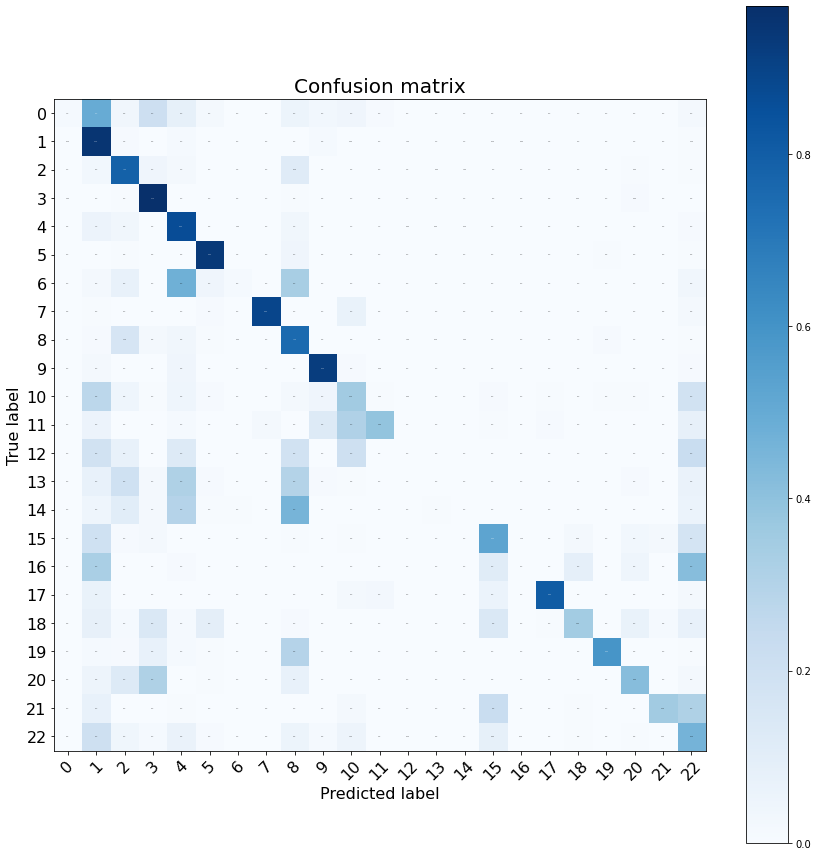

In [ ]:
import sklearn.metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.rcParams['xtick.top'] = True
    plt.rcParams['xtick.bottom'] = False 
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}%".format(cm[j][i] * 100),        
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=0) 

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

plt.figure(figsize=(12,12))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=list(range(23)), normalize=True, 
                      title='Confusion matrix', cmap = plt.cm.Blues)

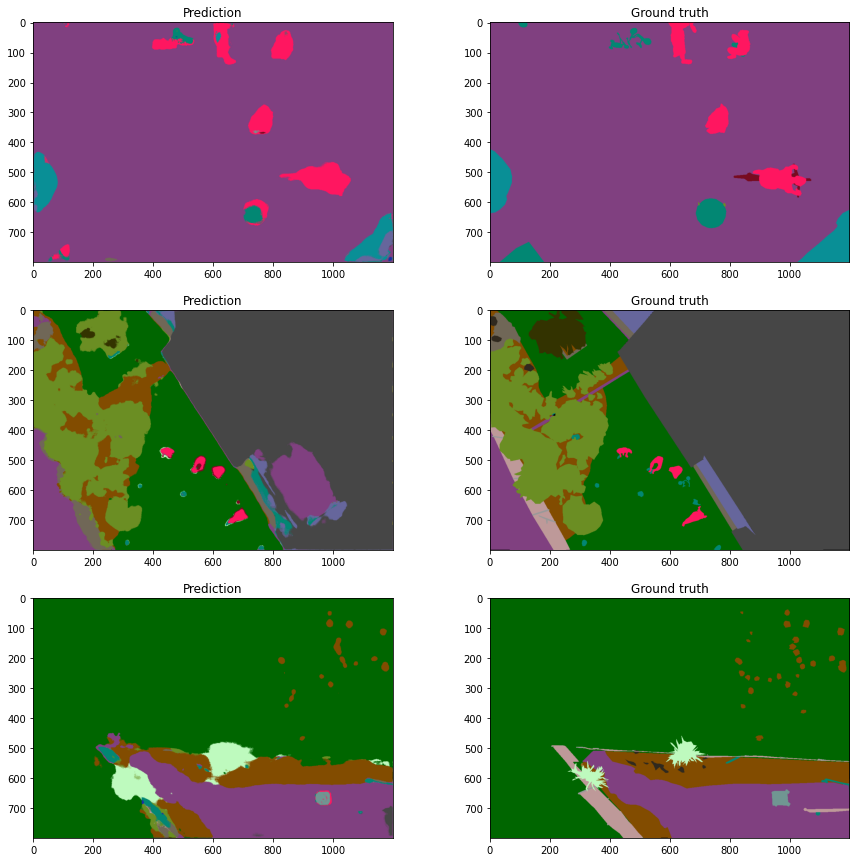

In [ ]:
y_pred = y_pred.reshape(-1, 800, 1200)
y_true = y_true.reshape(-1, 800, 1200)

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for j in range(3):
    ax[j, 0].imshow(cmap[y_pred[j]])
    ax[j, 1].imshow(cmap[y_true[j]])
    ax[j, 0].set_title('Prediction')
    ax[j, 1].set_title('Ground truth')
plt.show()

In [ ]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)

Potential updates:
- experiment with alternative loss functions eg. dice coef loss, jaccard loss, (sparse) cross-entropy loss, focal loss func (may perform better than weighted loss functions for multi-class tasks)